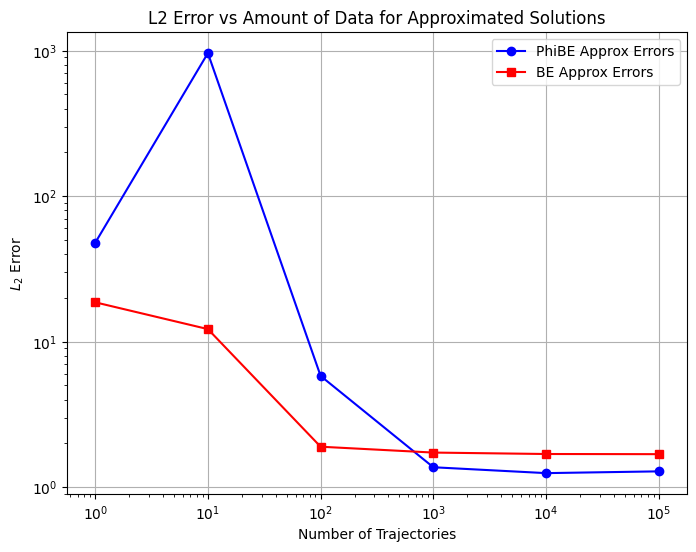

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Parameters
lambda_ = 0.05
delta_t = 5
beta = 0.1
k = 1
M = 40  
m = 4   

# True value function
def V_true(s):
    return np.cos(k * s) ** 3

def reward_function(s):
    reward = beta * np.cos(k * s) ** 3 - lambda_ * s * (-3 * k * np.cos(k * s)**2 * np.sin(k * s))
    reward -= (1/2)*(6 * k**2 * np.cos(s) * np.sin(k*s)**2 - 3* k**2 * np.cos(k*s)**3)
    return reward


# Function to compute L2 error
def L2_error(V_approx):
    integrand = lambda s: (V_true(s) - V_approx(s)) ** 2
    error = np.sqrt(quad(integrand, -np.pi, np.pi)[0])
    return error

# List of data amounts
data_amounts = [1,10,10**2,10**3,10**4,10**5]

# Arrays to store errors
PhiBE_approx_errors = []
BE_approx_errors = []

for num_trajectories in data_amounts:
    trajectories = []
    s_0_values = np.linspace(-np.pi, np.pi, num_trajectories)
    
    for s_0 in s_0_values:
        traj = [s_0]
        r_traj = []
        s_prev = s_0
        for _ in range(m):
            mean = s_prev * np.exp(-lambda_ * delta_t)
            variance = (1 / (2 * lambda_)) * (1 - np.exp(-2 * lambda_ * delta_t))
            s_next = np.random.normal(mean, np.sqrt(variance))
            traj.append(s_next)
            s_prev = s_next
        trajectories.append(traj)
    
    # Approximate PhiBE solution using Algorithm 2
    def bases(s):
        bases=[1/np.sqrt(2*np.pi)]
        for m in range(1,M+1):
            bases.append(np.cos(m*s)/np.sqrt(np.pi))
            bases.append(np.sin(m*s)/np.sqrt(np.pi))
        return np.array(bases).reshape(-1,1)   #return column vector

    def gradient_bases(s):
        gradient_bases=[0]
        for m in range(1,M+1):
            gradient_bases.append(-m*np.sin(m*s)/np.sqrt(np.pi))
            gradient_bases.append(m*np.cos(m*s)/np.sqrt(np.pi))
        return np.array(gradient_bases).reshape(-1,1)  
    
    def gra_gradient_bases(s):
        gradient_bases=[0]
        for m in range(1,M+1):
            gradient_bases.append(-m**2*np.cos(m*s)/np.sqrt(np.pi))
            gradient_bases.append(-m**2*np.sin(m*s)/np.sqrt(np.pi))
        return np.array(gradient_bases).reshape(-1,1)
    

    A_PhiBE = np.zeros((2 * M + 1, 2 * M + 1))
    b_PhiBE = np.zeros((2 * M + 1, 1))
    
    for traj in trajectories:
        for j in range(m-1):
            s_j = traj[j]
            mu = (traj[j+1]-traj[j])/delta_t
            sigma = (traj[j+1]-traj[j])**2 /delta_t
            A_PhiBE += bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j) - (sigma/2)  * gra_gradient_bases(s_j)).T
            b_PhiBE += reward_function(s_j) * bases(s_j)
    
    theta_PhiBE = np.linalg.solve(A_PhiBE, b_PhiBE)
    

    def V_PhiBE_approx(s):
        return (theta_PhiBE.T @ bases(s)).item()

    PhiBE_approx_error = L2_error(V_PhiBE_approx)
    PhiBE_approx_errors.append(PhiBE_approx_error)
    
    # Approximate BE solution using LSTD
    A_BE = np.zeros((2 * M + 1, 2 * M + 1))
    b_BE = np.zeros((2 * M + 1, 1))
    
    for traj in trajectories:
        for j in range(m-1):
            s_j = traj[j]
            s_j_next = traj[j+1]
            mu = (traj[j+1]-traj[j])/delta_t
            sigma = (traj[j+1]-traj[j])**2 /delta_t
            A_BE += bases(s_j)@(bases(s_j) - np.exp(-beta*delta_t) * bases(s_j_next)).T 
            b_BE += reward_function(s_j) * bases(s_j)
    
    theta_BE = np.linalg.solve(A_BE, b_BE)
    

    def V_BE_approx(s):
        return (theta_BE.T @ bases(s)).item()
    

    BE_approx_error = L2_error(V_BE_approx)
    BE_approx_errors.append(BE_approx_error)


plt.figure(figsize=(8, 6))
plt.loglog(data_amounts, PhiBE_approx_errors, label='PhiBE Approx Errors', marker='o', color='b')
plt.loglog(data_amounts, BE_approx_errors, label='BE Approx Errors', marker='s', color='r')
plt.xlabel('Number of Trajectories')
plt.ylabel('$L_2$ Error')
plt.title('L2 Error vs Amount of Data for Approximated Solutions')
plt.legend()
plt.grid(True)
plt.show()


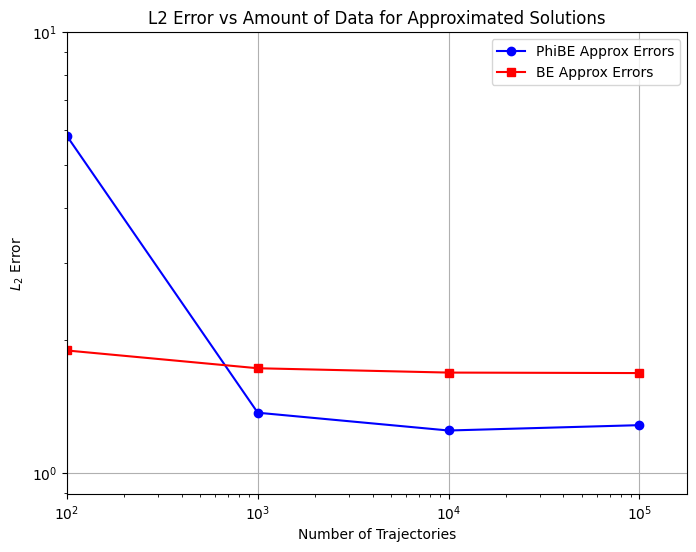

In [5]:
plt.figure(figsize=(8, 6))
plt.loglog(data_amounts, PhiBE_approx_errors, label='PhiBE Approx Errors', marker='o', color='b')
plt.loglog(data_amounts, BE_approx_errors, label='BE Approx Errors', marker='s', color='r')
plt.xlabel('Number of Trajectories')
plt.ylabel('$L_2$ Error')
plt.title('L2 Error vs Amount of Data for Approximated Solutions')
plt.legend()
plt.grid(True)
plt.xlim(left=10**2)
plt.ylim(0, 10)
plt.show()
